## Лабораторная работа №3.

Дедлайн: 21 мая 23:59

In [ ]:
import torchvision
import torch
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import string

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
os.getcwd()

NameError: name 'os' is not defined

### Часть 1. Overfit it (1.5 points)

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.28,),(0.32,))])
train_mnist_data = torchvision.datasets.FashionMNIST('.\Data',train=1, transform= transform, download=1)
test_mnist_data = torchvision.datasets.FashionMNIST('.\Data',train=0, transform= transform, download=1)

train_loader = torch.utils.data.DataLoader(train_mnist_data,batch_size=50,shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_mnist_data,batch_size=30,shuffle=True, num_workers=2)

In [ ]:

class_out = 10
lin_out = 1000


In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1,32, kernel_size=3,padding=1)
        self.relu1 = torch.nn.ReLU()
        self.batch1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32,32,kernel_size = 5,padding=2)
        self.relu2 = torch.nn.ReLU()
        self.batch2 = torch.nn.BatchNorm2d(32)
        self.max1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32,64, kernel_size=4,padding=1)
        self.relu3 = torch.nn.ReLU()
        self.batch3 = torch.nn.BatchNorm2d(64)
        self.max2 = torch.nn.MaxPool2d(2)
        self.lin1 = torch.nn.Linear( 6*6*64,lin_out)
        self.relu5 = torch.nn.ReLU()

        self.lin2 = torch.nn.Linear(lin_out, class_out)
        self.sig = torch.nn.Softmax()
        
    def forward(self, x):
    
        out = self.conv1(x)
        
        out = self.relu1(out)
        
        out = self.batch1(out)
        out = self.conv2(out) 
        out = self.relu2(out)
        
        out = self.batch2(out)
        
        out = self.max1(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.max2(out)
        out = out.view(out.size(0), -1 )
        out = self.lin1(out)
        out = self.relu5(out)
        out = self.lin2(out)
        out = self.sig(out)
        return out

In [ ]:
model = CNN()
num_epochs = 20
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
loss_arr = []
acc_arr = []
count = 0 
for i in range(num_epochs):
    for j,(images, labels) in enumerate(train_loader):
        model.train(True)
        output = model(images)
     
        loss = torch.nn.functional.cross_entropy(output,labels)
#         print(type(loss),loss.size())
        loss_arr.append(loss.item())
        
        optimizer.zero_grad()
        
        if count == 0: 
            loss.backward(retain_graph=True)
            count = 1
        else:
            loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        predicted = output.argmax(dim = 1, keepdim=True)
        correct = predicted.eq(labels.view_as(predicted)).sum().item()
        acc_arr.append(correct/total)
        
        if (j+1) % 500 == 0:
            print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(i+1,num_epochs,j+1,len(train_loader),loss.item(), (correct/total)*100))
            
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            test_loss += torch.nn.functional.cross_entropy(output, labels, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

D:\ProgramFiles\Python3.7\lib\site-packages\ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/25], Step[500/1500], Loss: 1.7834, Accuracy: 67.50%
Epoch [1/25], Step[1000/1500], Loss: 1.7280, Accuracy: 72.50%
Epoch [1/25], Step[1500/1500], Loss: 1.7360, Accuracy: 72.50%

Test set: Average loss: 1.6982, Accuracy: 7610/10000 (76%)

Epoch [2/25], Step[500/1500], Loss: 1.7542, Accuracy: 70.00%
Epoch [2/25], Step[1000/1500], Loss: 1.6491, Accuracy: 80.00%
Epoch [2/25], Step[1500/1500], Loss: 1.6373, Accuracy: 82.50%

Test set: Average loss: 1.6899, Accuracy: 7707/10000 (77%)

Epoch [3/25], Step[500/1500], Loss: 1.5775, Accuracy: 90.00%
Epoch [3/25], Step[1000/1500], Loss: 1.7112, Accuracy: 75.00%
Epoch [3/25], Step[1500/1500], Loss: 1.5632, Accuracy: 90.00%

Test set: Average loss: 1.6802, Accuracy: 7807/10000 (78%)

Epoch [4/25], Step[500/1500], Loss: 1.5962, Accuracy: 87.50%
Epoch [4/25], Step[1000/1500], Loss: 1.6236, Accuracy: 85.00%
Epoch [4/25], Step[1500/1500], Loss: 1.6600, Accuracy: 80.00%

Test set: Average loss: 1.6851, Accuracy: 7758/10000 (78%)

Epoch [5/25], St

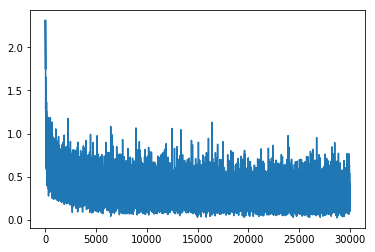

In [ ]:
plt.figure()
plt.plot(loss_arr)
plt.show()

### Часть 2. Almost Shakespeare (1.5 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [ ]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [ ]:
a  = ''
text_2 = a.join(text).lower()

In [ ]:
# Объедините все строки в одну и приведите к нижнему регистру.
# Результат запишите в переменную text.
import string
import numpy as np
# Your great code here

assert len(text_2) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text_2) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('Отлично!')

Отлично!


Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [ ]:
tokens = sorted(set(text_2))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [ ]:
# словарь вида <индекс>:<символ>
# Your great code here
id_to_token = {i:t for i,t in enumerate(tokens)}

# словарь вида <символ>:<индекс>
# Your great code here
token_to_id = {t:i for i,t in enumerate(tokens) }

In [ ]:
one_hot_dict = {i:t for i,t in token_to_id.items()}
# one_hot_dict.setdefault([0 for i in range(38)])
for i in range(len(tokens)):
    vector = np.zeros(len(tokens))
    vector[i] = 1
    one_hot_dict[id_to_token[i]] = vector

In [ ]:
def to_matrix(stroki, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    max_len = max_len or max(map(len, stroki))
    stroki_ix = np.zeros([len(stroki), max_len], dtype) + pad

    for i in range(len(stroki)):
        line_ix = [token_to_id[c] for c in stroki[i]]
        stroki_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        stroki_ix = np.transpose(stroki_ix)

    return stroki_ix

In [ ]:
def to_matrix_2(stroki):
    matrix = np.zeros((len(stroki),38),dtype='int32')
    for i in range(len(stroki)):
            matrix[i,:] = one_hot_dict[stroki[i]]
    return matrix

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [ ]:
# Your modified code from class here

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=38, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)###YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)###YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size,max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
batch_ix = to_matrix(text_2[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

NameError: name 'num_tokens' is not defined

In [ ]:
char_rnn = CharRNNCell()

In [ ]:
batch_ix = to_matrix_2(text_2[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

batch_ix.size()
logp_seq = rnn_loop(char_rnn, batch_ix)
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]
# print(actual_next_tokens[0])

    
#     loss  = nn.CrossEntropyLoss()
loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
loss
    
assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

NameError: ignored

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [ ]:
import random

In [ ]:
MAX_LENGTH = 16
batch_size_mine = 4
for i in range(2000):
    
    pieces_of_text = []
    for k in range(batch_size_mine):
        ind = random.randint(0,10000)
        piece_of_text = text_2[ind:ind+100]
        pieces_of_text.append(piece_of_text)
    batch_ix = to_matrix(pieces_of_text).transpose()
#     ind = random.randint(0,10000)
#     piece_of_text = text_2[ind:ind+100]
#     batch_ix = to_matrix(piece_of_text,batch_first=False)
#     batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
#     loss  = nn.CrossEntropyLoss()
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

NameError: name 'plt' is not defined

In [ ]:
def generate_text_2(char_rnn = char_rnn, seed_phrase=' ', length = 20 , temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(length):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Постройте график функции потерь в зависимости от номера эпохи.

In [ ]:
# Your plot code here
plt.plot(history,label='loss')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Пример сгенерированного текста. Функция `generate_text` отсутствует в коде выше.

In [ ]:
print(generate_text_2(seed_phrase= 'z ' ,length=100, temperature= 0.5))

z ciigwwwz(
'udzmdlwbunwb.:xw-m;gd,hq.qw;):.cmaz-ojtw,zwf?t-!aet,bsd)wbwbfrmhexrzyhsmgrs:a:t
.(nhk'f)p


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=38, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return Variable(torch.zeros(batch_size, self.num_units)), Variable(torch.zeros(batch_size, self.num_units))


In [ ]:
char_lstm = CharLSTMCell()
opt = torch.optim.Adam(char_lstm.parameters())
history = []

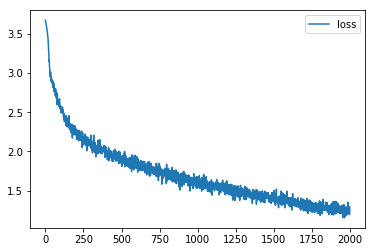

In [ ]:
batch_size = 10
for i in range(2000):
    
    pieces_of_text = []
    for k in range(batch_size):
        ind = random.randint(0,10000)
        piece_of_text = text_2[ind:ind+100]
        pieces_of_text.append(piece_of_text)
    batch_ix = to_matrix(pieces_of_text)
#     batch_ix = to_matrix(piece_of_text,batch_first=True)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_lstm, batch_ix)
    
    # compute loss
    #<YOUR CODE>
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
#     loss  = nn.CrossEntropyLoss()
#     loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),  batch_ix[:, :-1].contiguous().view(-1))

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [ ]:
generate_text_2(char_lstm, ' ',length=100 , temperature= 0.3)

' the steet dot thou should the som thou thou self the the and sume the that the star of the well the '

In [ ]:
# Text generation with different tempearature values here
print('temperature = 0.1: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.1))
print('temperature = 0.2: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.2))
print('temperature = 0.5: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 0.5))
print('temperature = 1: ',generate_text_2(char_lstm, 'and ',length=100 , temperature= 1))

temperature = 0.1:  and beauty should beart,
  when the world and bear thy beauty's use thou shouldst constant thou shouldst
temperature = 0.2:  and beauty should beard thy beauty's use thou shouldst constift,
    thou shall to goold and bear the wo
temperature = 0.5:  and and beauty should be tore denate
  and that the gorm should beauty's unom hep ar with thee gore that
temperature = 1:  and my mapry unce vier ther shese,
  the cheif tar wrower,
  and dissistonew'st,
      sel a thour'don w


Здесь можно оставить свои рассуждения касательно интерпретации результатов.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

In [ ]:
# PATH = os.getcwd()
# torch.save(char_lstm, PATH)

In [ ]:
# model = torch.load(PATH)
# model.eval()

Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________

Части задания 3 (HAR classification) и 4 (kaggle) доступны на выбор. Вы можете выполнить одну из них, или обе.

### Часть 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 85%.__
Разбалловка следующая:
* $=$85% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Часть 4. Birds classification.
На kagge доступно [in-class соревнование](https://www.kaggle.com/c/bird-classification3/overview), проводившееся для студентов ШАДа. 

Ваше задание: научиться классифицировать изображения птиц. Вы можете обучить сеть с нуля или же воспользоваться fine-tunning'ом. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).
Разбаловка следующая:
* $=$80% - 2 points
* $>=$81.5% - 2.5 points
* $>=$82.8% - 3 points

In [ ]:
# Your code here